# Predicting Categories of Bank Transaction Data

This notebook combines all three other notebooks (`data_preprocessing.ipynb`, `model_training.ipynb` and `model_inference.ipynb`) as a single pipeline that runs from end to end.

- Author: Chau Jia Yi
- Date: 11/2/2025

## Data Preprocessing 

This section preprocesses two raw datasets (`bank_transaction.csv` and `user_profile.csv`) to serve as training inputs to the model later.

### Data Cleaning and Merging

#### Loading Data & Inspect for Missing Values

In [1]:
import pandas as pd
import random
import numpy as np
import gensim
from gensim.models import FastText

SEED = 42

# Set all random seeds
random.seed(SEED)
np.random.seed(SEED)
gensim.utils.random.seed(SEED)

# Load datasets
bank_transaction = pd.read_csv("../dataset/bank_transaction.csv")
user_profile = pd.read_csv("../dataset/user_profile.csv")

# Display first few rows
display(bank_transaction.head())
display(user_profile.head())

,client_id,bank_id,account_id,txn_id,txn_date,description,amount,category
0,1,1,1,4,2023-09-29 00:00:00,Earnin PAYMENT Donat...,20.0,Loans
1,1,1,1,3,2023-08-14 00:00:00,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,Transfer Credit
2,1,1,1,5,2023-09-25 00:00:00,MONEY TRANSFER AUTHOR...,20.0,Loans
3,1,1,2,1,2023-06-02 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,Transfer Credit
4,1,1,2,2,2023-06-01 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,Transfer Credit


,CLIENT_ID,IS_INTERESTED_INVESTMENT,IS_INTERESTED_BUILD_CREDIT,IS_INTERESTED_INCREASE_INCOME,IS_INTERESTED_PAY_OFF_DEBT,IS_INTERESTED_MANAGE_SPENDING,IS_INTERESTED_GROW_SAVINGS
0,1,False,False,False,False,False,False
1,2,False,False,False,False,False,False
2,3,False,False,False,False,False,False
3,4,False,True,True,True,True,True
4,5,True,False,True,True,True,False


In [2]:
print("Missing values in bank_transaction dataset:")
print(bank_transaction.isnull().sum())

print("\nMissing values in user_profile dataset:")
print(user_profile.isnull().sum())

Missing values in bank_transaction dataset:
client_id        0
bank_id          0
account_id       0
txn_id           0
txn_date         0
description      0
amount           0
category       257
dtype: int64

Missing values in user_profile dataset:
CLIENT_ID                        0
IS_INTERESTED_INVESTMENT         0
IS_INTERESTED_BUILD_CREDIT       0
IS_INTERESTED_INCREASE_INCOME    0
IS_INTERESTED_PAY_OFF_DEBT       0
IS_INTERESTED_MANAGE_SPENDING    0
IS_INTERESTED_GROW_SAVINGS       0
dtype: int64


In [3]:
# print total number of rows in both bank_transaction and user_profile dataset
print("\nTotal number of rows in bank_transaction dataset: ", bank_transaction.shape[0])
print("Total number of rows in user_profile dataset: ", user_profile.shape[0])


Total number of rows in bank_transaction dataset:  258779
Total number of rows in user_profile dataset:  1000


#### Merging `bank_transaction.csv` with `user_profile.csv`

Incorporating `user_profile.csv` dataset is useful as 
- Financial behaviour may vary by user interests. E.g. Users interested in "Grow Savings" may have more deposit transactions. Including this data adds personalized financial behavior insights to the model.
- The model may find user-specific spending patterns.

In [4]:
# Convert all column names to lowercase
bank_transaction.columns = bank_transaction.columns.str.lower()
user_profile.columns = user_profile.columns.str.lower()

# merge both datasets on client_id
df = pd.merge(bank_transaction, user_profile, on='client_id', how='inner')

# Display first few rows of merged dataset
display(df.head())

,client_id,bank_id,account_id,txn_id,txn_date,description,amount,category,is_interested_investment,is_interested_build_credit,is_interested_increase_income,is_interested_pay_off_debt,is_interested_manage_spending,is_interested_grow_savings
0,1,1,1,4,2023-09-29 00:00:00,Earnin PAYMENT Donat...,20.0,Loans,False,False,False,False,False,False
1,1,1,1,3,2023-08-14 00:00:00,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,Transfer Credit,False,False,False,False,False,False
2,1,1,1,5,2023-09-25 00:00:00,MONEY TRANSFER AUTHOR...,20.0,Loans,False,False,False,False,False,False
3,1,1,2,1,2023-06-02 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,Transfer Credit,False,False,False,False,False,False
4,1,1,2,2,2023-06-01 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,Transfer Credit,False,False,False,False,False,False


#### Dropping rows with missing labels

Only 257 rows out of 258,779 (~0.1%) have missing category labels, this suggests those missing values are likely random and not part of a structured evaluation set. Keeping them could introduce noise.

In [5]:
df = df.dropna(subset=['category'])

# Verify the dataset after removal
print(f"Remaining rows after removing missing categories: {df.shape[0]}")

Remaining rows after removing missing categories: 258522


#### Removing unnecessary features

Some features may not be relevant for predicting transaction categories. Features like `client_id`, `bank_id` and `account_id`, and `txn_id` are raw identifiers that might not generalize well to new, unseen users/banks/accounts/transactions.

Dropping those columns ensures that the model focuses on real transaction-specific features like `description`, `amount`, and `txn_date`, which are more universally useful.

*However, they may still provide valuable transaction behavior insights to the model when encoded properly via feature engineering (mean, min, max, sum)*.

In [6]:
# Dropping client_id, bank_id, account_id, and txn_id columns
df = df.drop(columns=['client_id', 'bank_id', 'account_id', 'txn_id'])

# Move the target column to the last
df = df[[col for col in df if col != 'category'] + ['category']]

# Display first few rows of the dataset
display(df.head())

,txn_date,description,amount,is_interested_investment,is_interested_build_credit,is_interested_increase_income,is_interested_pay_off_debt,is_interested_manage_spending,is_interested_grow_savings,category
0,2023-09-29 00:00:00,Earnin PAYMENT Donat...,20.0,False,False,False,False,False,False,Loans
1,2023-08-14 00:00:00,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,False,False,False,False,False,False,Transfer Credit
2,2023-09-25 00:00:00,MONEY TRANSFER AUTHOR...,20.0,False,False,False,False,False,False,Loans
3,2023-06-02 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,False,False,False,False,False,False,Transfer Credit
4,2023-06-01 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,False,False,False,False,False,False,Transfer Credit


### Data Encoding and Normalisation

#### One-Hot Encoding for Categorical Data

1. User interest columns from `user_profile.csv` (IS_INTERESTED_* columns are already boolean).
2. Transaction category (category) from `bank_transaction.csv`.

In [7]:
# One-hot encode user interest columns (Boolean → Binary 0/1)
user_interest_cols = [
    'is_interested_investment', 'is_interested_build_credit',
    'is_interested_increase_income', 'is_interested_pay_off_debt',
    'is_interested_manage_spending', 'is_interested_grow_savings'
]
df[user_interest_cols] = df[user_interest_cols].astype(int)

# One-hot encode the target variable (category)
df = pd.get_dummies(df, columns=['category'], prefix='category')

category_cols = [col for col in df.columns if col.startswith("category_")]
df[category_cols] = df[category_cols].astype(int)

# Display updated dataset
display(df.head())

,txn_date,description,amount,is_interested_investment,is_interested_build_credit,is_interested_increase_income,is_interested_pay_off_debt,is_interested_manage_spending,is_interested_grow_savings,category_ATM,...,category_Tax Refund,category_Telecommunication Services,category_Third Party,category_Transfer,category_Transfer Credit,category_Transfer Debit,category_Transfer Deposit,category_Travel,category_Uncategorized,category_Utilities
0,2023-09-29 00:00:00,Earnin PAYMENT Donat...,20.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-14 00:00:00,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2023-09-25 00:00:00,MONEY TRANSFER AUTHOR...,20.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-06-02 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2023-06-01 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Encoding `txn_date`

In [8]:
# Convert txn_date to datetime format (if not already in datetime)
df['txn_date'] = pd.to_datetime(df['txn_date'], errors='coerce')

# Extract time-based features
df['day_of_week'] = df['txn_date'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_month'] = df['txn_date'].dt.day  # 1-31
df['hour'] = df['txn_date'].dt.hour  # Extract hour from transaction time (0-23)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 1=Weekend, 0=Weekday

# Drop original txn_date column
df = df.drop(columns=['txn_date'])

# Display updated dataset
display(df.head())

,description,amount,is_interested_investment,is_interested_build_credit,is_interested_increase_income,is_interested_pay_off_debt,is_interested_manage_spending,is_interested_grow_savings,category_ATM,category_Arts and Entertainment,...,category_Transfer Credit,category_Transfer Debit,category_Transfer Deposit,category_Travel,category_Uncategorized,category_Utilities,day_of_week,day_of_month,hour,is_weekend
0,Earnin PAYMENT Donat...,20.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,29,0,0
1,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,14,0,0
2,MONEY TRANSFER AUTHOR...,20.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,25,0,0
3,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,4,2,0,0
4,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,3,1,0,0


#### Normalizing transaction `amount` Using Z-Score

In [9]:
from sklearn.preprocessing import StandardScaler
import pickle
import os

# Initialize Standard Scaler
scaler = StandardScaler()

# Select numerical features to scale
numerical_features = ['amount', 'day_of_week', 'day_of_month', 'hour']

# Fit scaler on the training data & transform it
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Save the trained scaler to a file for use in training & inference
SCALER_PATH = "../models/scaler/scaler.pkl"
os.makedirs(os.path.dirname(SCALER_PATH), exist_ok=True)
# with open(SCALER_PATH, "wb") as f:
#     pickle.dump(scaler, f)

# Check the scaled values
print(df[numerical_features].describe())

             amount   day_of_week  day_of_month          hour
count  2.585220e+05  2.585220e+05  2.585220e+05  2.585220e+05
mean   1.231319e-17  2.176797e-17  1.594119e-16 -2.094342e-17
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00
min   -1.129187e+02 -1.240304e+00 -1.703148e+00 -3.006417e-01
25%   -1.053363e-01 -1.240304e+00 -9.137470e-01 -3.006417e-01
50%   -5.457531e-02 -1.206484e-01 -1.157457e-02 -3.006417e-01
75%   -6.771250e-03  9.990077e-01  8.905979e-01 -3.006417e-01
max    1.157558e+02  2.118664e+00  1.679999e+00  4.479723e+00


#### Check for class imbalance

In [10]:
# Count the number of instances for each category
category_counts = df.filter(like="category_").sum().sort_values(ascending=False)

# Compute percentage distribution
total_samples = category_counts.sum()
category_percentages = (category_counts / total_samples) * 100

# Print class distribution in percentage
print("\nCategory Percentage Distribution:")
print(category_percentages)

# Get all one-hot encoded category columns
category_cols = [col for col in df.columns if col.startswith("category_")]

# Count the number of unique transaction categories
num_classes = len(category_cols)

print(f"Total number of unique transaction categories: {num_classes}")


Category Percentage Distribution:
category_Uncategorized                 11.369245
category_Third Party                   11.106985
category_Restaurants                   10.199132
category_Transfer Credit                8.340103
category_Loans                          7.583494
category_Convenience Stores             7.206350
category_Supermarkets and Groceries     6.479139
category_Transfer Debit                 5.846311
category_Gas Stations                   4.997254
category_Internal Account Transfer      4.635195
category_Payroll                        3.133196
category_Shops                          2.869388
category_Bank Fees                      2.487989
category_Transfer                       2.427260
category_ATM                            2.194011
category_Transfer Deposit               1.924788
category_Digital Entertainment          1.750335
category_Utilities                      1.592901
category_Clothing and Accessories       1.233938
category_Department Stores        

Based on the category percentage distribution, the dataset is imbalanced as some categories have significantly more instances than others.

To deal with class imbalance, use class weighting to penalize mistakes in minority classes more than in majority classes. This ensures that the model does not become biased toward the dominant class. Without class weights, each class contributes equally to the loss. This can be a problem if the dataset is highly imbalanced.

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

category_cols = [col for col in df.columns if col.startswith("category_")]

# Compute class weights (inverse of class frequency)
class_weights = compute_class_weight(
    class_weight="balanced",  # Assigns higher weights to minority classes
    classes=np.arange(len(category_cols)),  # Class indices
    y=df[category_cols].values.argmax(axis=1)  # Convert one-hot to class index
)

# Convert to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the class weights to a file for use in training
CLASS_WEIGHTS_PATH = "../models/class_weights/class_weights.pkl"
os.makedirs(os.path.dirname(CLASS_WEIGHTS_PATH), exist_ok=True)
with open(CLASS_WEIGHTS_PATH, "wb") as f:
    pickle.dump(class_weights_dict, f)

### Text Preprocessing (Transaction Description)

#### Text Cleaning & Normalization & NER

The following are the text cleaning rules that I can think of:
- Lowercasing: Convert all text to lowercase.
- Removing punctuation & special characters: Strip unnecessary punctuation (except when part of a business name).
- Removing extra spaces: Ensure clean, space-separated tokens.
- Lemmatization: Convert words to their base form (e.g., "running" → "run").
- Removing stopwords: Remove common words like "the," "is," "on" that don't contribute meaning.
- Removing numbers (unless part of a business name): Numbers alone are removed, but business names with numbers are retained.
- Removing natural person names (PERSON from NER): Do not provide information.
- Keeping business names (ORG from NER): Business names are valuable in transaction classification and are preserved.
- Removing locations & dates (GPE, DATE from NER): Location and date details are unnecessary and are removed.
- Removing identifiers or serial numbers: Example: "84DD466B7C25425" and "8445052993ca" are removed.

However, if numbers and letters are clearly separated in a business name (ORG), numbers are stripped while keeping the entity.
Example: "5631moneylion" → "moneylion", "999venmo888" → "venmo".

In [12]:
import spacy
import pandas as pd
import re
from tqdm import tqdm

# Load SpaCy model
nlp = spacy.load("en_core_web_lg")

# Enable tqdm with Pandas for progress bars
tqdm.pandas()

# Dictionary to expand common abbreviations in the text
ABBR_DICT = {
    'ckg': 'checking', 'chk': 'check', 'dep': 'deposit', 'trns': 'transfer',
    'adv': 'advance', 'w/d': 'withdrawal', 'wd': 'withdrawal', 'xfer': 'transfer',
    'pmt': 'payment', 'txn': 'transaction', 'int': 'interest', 'intl': 'international',
    'intr': 'interest', 'chg': 'charge', 'pos': 'point of sale',
    'purch': 'purchase', 'atm': 'cash machine', 'atw': 'cash machine',
    'cd': 'certificate of deposit', 'cc': 'credit card', 'dc': 'debit card',
    'bal': 'balance', 'adj': 'adjustment', 'adjmt': 'adjustment', 'apmt': 'automatic payment',
    'av': 'available', 'bk': 'bank', 'bkcard': 'bank card',
    'bkchg': 'bank charge', 'bkfee': 'bank fee', 'bkln': 'bank loan',
    'bkstmt': 'bank statement', 'bktrns': 'bank transfer', 'bkwd': 'bank withdrawal',
    'blnc': 'balance', 'bnk': 'bank', 'bnkchg': 'bank charge', 'n': "and", 'tx': 'transaction', 
    'cb': 'chase bank', 'trsf': 'transfer', 'ref': 'reference', 'pymt': 'payment', 'pymnt': 'payment', 
    'pmnt': 'payment', 'pw': '', 'ml': '', 'rcvd': 'received', 'dbt': 'debit', 'crd': 'card',
    'mar': 'mart', 'stor': 'store', 'sup': 'supermarket'
}

# Set of terms to remove from the text
REMOVED_TERMS = {
    'ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 
    'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 
    'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 
    'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy', 'rd',
    'date', 'card'
}

# Set of terms to keep in the text (e.g., specific company names)
KEPT_TERMS = {
    '7-eleven', '7eleven', '7 eleven', 'walmart', 'circle k', 'target', 'costco', 'sams club'
}

# Regex patterns for identifying dates, digits, colons/slashes, special characters, and repeated spaces
DATE_PATTERN = re.compile(r'\b(?:\d{1,2}[-/]\d{1,2}(?:[-/]\d{2,4})?|\d{4}[-/]\d{1,2}[-/]\d{1,2})\b')
DIGITS_PATTERN = re.compile(r'\d+')
COLON_SLASH_PATTERN = re.compile(r'[:/]')
REPEATED_SPACES = re.compile(r'\s+')

def is_interleaved_alphanumeric(text):
    """Check if text has interleaved letters and numbers"""
    is_digit_prev = text[0].isdigit()
    transitions = 0
    for char in text[1:]:
        is_digit_curr = char.isdigit()
        if is_digit_curr != is_digit_prev:
            transitions += 1
        is_digit_prev = is_digit_curr
    return transitions > 2

def extract_potential_entity(text):
    """Extract letters from alphanumeric text if clearly separated"""
    if is_interleaved_alphanumeric(text):
        return None
    return DIGITS_PATTERN.sub('', text).strip()

def clean_normalize_text(text):
    """Clean and normalize text by expanding abbreviations, removing unwanted terms, and processing with SpaCy."""
    text = text.lower()
    
    # Check for kept terms before any processing
    for kept_term in KEPT_TERMS:
        if kept_term in text:
            return kept_term
        
    words = text.split()
    expanded_words = [ABBR_DICT.get(word.lower(), word) for word in words]
    text = ' '.join(expanded_words)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s-]', ' ', text)
    
    # Process text with SpaCy to tokenize and analyze entities
    doc = nlp(text)
    
    cleaned_tokens = []
    for token in doc:
        word = token.text.lower()
        
        # Remove entities: person names, locations, dates
        if token.ent_type_ in ['PERSON', 'GPE', 'DATE']:
            continue
        
        # Remove date patterns
        if DATE_PATTERN.search(word):
            continue

        # Remove words containing ":" or "/"
        if COLON_SLASH_PATTERN.search(word):
            continue
        
        # Skip if word is a state abbreviation
        if word in REMOVED_TERMS:
            continue
        
        # Keep organization names
        if token.ent_type_ == 'ORG':
            cleaned_tokens.append(token.text)
            continue
        
        # Handle alphanumeric words
        if any(c.isdigit() for c in word) and any(c.isalpha() for c in word):
            entity_name = extract_potential_entity(word)
            if entity_name:
                cleaned_tokens.append(entity_name.lower())
            continue
            
        # Skip punctuation, stopwords, numbers, and short words
        if (not token.is_punct and 
            not token.is_stop and 
            not token.like_num and 
            len(word) > 1):
            cleaned_tokens.append(token.lemma_)
            
    # Join tokens and clean up spaces
    result = ' '.join(cleaned_tokens)
    result = REPEATED_SPACES.sub(' ', result).strip()
    
    return result

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# df['processed_description'] = df['description'].progress_apply(clean_normalize_text)

# # Display the first few rows
# display(df[['description', 'processed_description']])


However, due to how Spacy handles tokenisation and its limited NLP capabilities, the outcome of text cleaning doesn't look very promising. Errors can be found. E.g. it got confused between entity names and person's names, and misunderstood the meanings of certain words.

#### Text Feature Extraction & Embeddings

Train a custom FastText Model fine-tunes embeddings on the actual transaction descriptions.
- Learns financial transaction-specific vocabulary, relationship between unique vendor names, abbreviations and industry-specific terms.
- Handles noisy transaction text better

In [13]:
# Load the cleaned description dataset
df = pd.read_csv("../bin/cleaned_description_bank_transaction.csv")

# pip install gensim
SEED = 42
import gensim
from gensim.models import FastText
gensim.utils.random.seed(SEED)

# Tokenize descriptions
df['tokenized_description'] = df['processed_description'].apply(lambda x: str(x).split() if pd.notna(x) else [])

# Train FastText model on your transaction descriptions
fasttext_model = FastText(
    sentences=df['tokenized_description'].tolist(), # Use preprocessed tokenised text as input for training
    vector_size=100, # Each word will be converted into a vector of size 100
    window=5, # FastText looks at 5 words before and after the target word
    min_count=1, 
    workers=1,
    sg=1  # Use Skip-gram (better for capturing rare words)
)

# Save model for future use
os.makedirs("../model/fasttext", exist_ok=True)
# fasttext_model.save("../model/fasttext/fasttext_model.bin")

Convert each transaction description into a numerical vector using the custom FastText model

In [14]:
def get_embedding(text):
    # Ensure text is a string and handle missing values
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return np.zeros(100)  # Return zero vector for empty/missing descriptions

    words = text.split()
    word_vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]

    if len(word_vectors) == 0:
        return np.zeros(100)  # Return zero vector if no words exist in FastText vocabulary

    return np.mean(word_vectors, axis=0)  # Take mean to get sentence-level embedding

df['fasttext_embedding'] = df['processed_description'].apply(get_embedding)

Convert embedding vector into separate feature columns:

Split the 100-dimensional embedding into 100 separate feature columns

In [15]:
# Convert FastText embedding list into separate columns
embedding_size = 100  # Vector size from FastText
embedding_cols = [f'fasttext_{i}' for i in range(embedding_size)]

# Convert each vector into multiple columns
embedding_df = pd.DataFrame(df['fasttext_embedding'].to_list(), columns=embedding_cols)

# Merge back with the main DataFrame
df = pd.concat([df, embedding_df], axis=1)

# Drop the original embedding column since it's now expanded
df = df.drop(columns=['fasttext_embedding'])


Final column rearrangement and cleaning

In [16]:
# Drop the original and processed description columns
df = df.drop(columns=['description', 'processed_description', 'tokenized_description'])

# Move the columns prefixed with category_ to the end
category_cols = [col for col in df.columns if col.startswith("category_")]
df = df[[col for col in df if col not in category_cols] + category_cols]

Saving the final preprocessed dataset

In [17]:
df.to_csv("../dataset/2_preprocessed_bank_transaction.csv", index=False)

## Model Training

Having preprocessed the dataset, this notebook builds and trains an ANN, hopefully be able to classify transaction category and achieve decent result.

#### Import Libraries

I'll be using the PyTorch framework to build and train the ANN. 

In [18]:

import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#### Load & Prepare Data

In [20]:
# Load the preprocessed data
df = pd.read_csv("../dataset/2_preprocessed_bank_transaction.csv")

# Extract all feature columns that are not prefixed with "category_"
feature_columns = [col for col in df.columns if not col.startswith("category_")]
X = df[feature_columns].values
print(X.shape)

(258522, 111)


In [21]:
# Extract all category columns
y = df.filter(like="category_").values 
print(y.shape)

(258522, 33)


#### Splitting into Training and Testing Set

The dataset will be splitted into 70% training and 30% testing set


In [22]:
# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float for BCE loss
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Print dataset shapes
print("Shape of X_train:", X_train_tensor.shape)
print("Shape of X_test:", X_test_tensor.shape)
print("Shape of y_train:", y_train_tensor.shape)
print("Shape of y_test:", y_test_tensor.shape)


Shape of X_train: torch.Size([180965, 111])
Shape of X_test: torch.Size([77557, 111])
Shape of y_train: torch.Size([180965, 33])
Shape of y_test: torch.Size([77557, 33])


#### Define the ANN Architecture

Since this is a multi-class classification problem (one-hot encoded category labels):

- Use fully connected layers
- Apply Batch Normalization for stable training
- Use Dropout to prevent overfitting
- Use Sigmoid activation at the output

In [23]:
# Define the ANN model
class TransactionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TransactionClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)  # Output layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for multi-label classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid for multi-label output
        return x

#### Load the Class Weights

The class weights have been calculated and saved during data preprocessing. It's can be used to adjust model weights later to deal with class imbalance if `use_class_weight` parameter is set to `True`.

In [24]:
import pickle

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the saved class weights
CLASS_WEIGHTS_PATH = "../models/class_weights/class_weights.pkl"

# Load the class weights
with open(CLASS_WEIGHTS_PATH, "rb") as f:
    class_weights_dict = pickle.load(f)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32).to(device)

#### Model Initialisation Function

- The argument `use_class_weights` determine whether to use **custom weighted** BCE loss to adjust the model weights for each class, or use the standard `BCELoss()` for training.
- Use Adam optimiser with learning rate 0.001

In [25]:
import torch.optim as optim
import torch.nn as nn

def initialize_model(input_size, num_classes, use_class_weights=False, class_weights=None, learning_rate=0.001):
    """Initialize the model, optimizer, and loss function with optional class weights."""
    
    # Initialize model
    model = TransactionClassifier(input_size, num_classes).to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define custom weighted BCE loss function
    def weighted_bce_loss(outputs, targets):
        """Applies class weights to BCEWithLogitsLoss."""
        loss = nn.BCELoss(reduction='none')(outputs, targets)  # Compute loss per class
        weighted_loss = loss * class_weights.to(device)  # Apply class weights
        return weighted_loss.mean()  # Return mean loss

    # Use weighted BCE loss if class weights are provided, else use standard BCE loss
    if use_class_weights and class_weights is not None:
        loss_fn = weighted_bce_loss
    else:
        loss_fn = nn.BCELoss()

    return model, optimizer, loss_fn


#### Initialising Model

In [26]:
input_size = X_train.shape[1]  # Total number of input features
num_classes = y_train.shape[1]  # Number of categories

use_class_weights = False

model, optimizer, loss_fn = initialize_model(
    input_size,
    num_classes,
    use_class_weights,
    class_weights=class_weights_tensor
)

# Print model summary
print(model)


TransactionClassifier(
  (fc1): Linear(in_features=111, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=33, bias=True)
  (sigmoid): Sigmoid()
)


#### Define Utility Functions

- Plot train vs test loss & accuracy over epochs
- Visualise confusion matrix & classification report
- Save model if `save_results` argument is `True`

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs, save_results, model_name):
    """Plot Train vs Test Loss & Accuracy side by side and optionally save results."""
    epochs = range(1, num_epochs+1)

    # Create side-by-side plots
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    # Plot Loss vs Epoch
    ax[0].plot(epochs, train_losses, label='Train Loss', marker='o')
    ax[0].plot(epochs, test_losses, label='Test Loss', marker='s')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss vs Test Loss')
    ax[0].legend()

    # Plot Accuracy vs Epoch
    ax[1].plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    ax[1].plot(epochs, test_accuracies, label='Test Accuracy', marker='s')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Train Accuracy vs Test Accuracy')
    ax[1].legend()

    if save_results:
        plt.savefig(f"../results/{model_name}/training_metrics.png")
        print(f"Training metrics saved at: ../results/{model_name}/training_metrics.png")

    plt.show()


def plot_confusion_matrix(all_labels, all_preds, category_names, save_results, model_name):
    """Compute and visualize the confusion matrix & classification report with real category names."""
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=category_names)

    # Increase figure size and use tight_layout
    fig, ax = plt.subplots(figsize=(14, 10))  # Adjust width and height if needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names, ax=ax)
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(category_names, rotation=90, ha="right")  # Rotate labels for better visibility
    ax.set_yticklabels(category_names, rotation=0)

    # Adjust layout to prevent cropping
    plt.tight_layout() 

    if save_results:
        save_path = f"../results/{model_name}/confusion_matrix.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)  # Save with bbox_inches to prevent cropping
        print(f"Confusion matrix saved at: {save_path}")

    plt.show()

    # Print classification report
    print(report)

    # Save classification report
    if save_results:
        with open(f"../results/{model_name}/classification_report.txt", "w") as f:
            f.write(report)
        print(f"Classification report saved at: ../results/{model_name}/classification_report.txt")


def save_model(model, model_name):
    """Save trained model and create directories."""
    # Create directories
    os.makedirs("../models/ann", exist_ok=True)
    os.makedirs(f"../results/{model_name}", exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), f"../models/ann/{model_name}.pth")
    print(f"Model saved at: ../models/ann/{model_name}.pth")


#### Define Train Test Function

- Train the model for an epoch.
- Evaluate the model on the test set after each epoch.
- Print Train Accuracy, Train Loss, Test Accuracy, and Test Loss.

In [28]:
import torch
from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, category_names, model_name, save_results, num_epochs=20, device="cpu"):
    model.to(device)

    # Lists to store loss and accuracy for visualization
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        for batch_X, batch_y in train_progress:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute loss
            running_train_loss += loss.item()

            # Compute instance-level accuracy
            predicted_classes = torch.argmax(outputs, dim=1)
            true_classes = torch.argmax(batch_y, dim=1)
            correct_train += (predicted_classes == true_classes).sum().item()
            total_train += batch_y.size(0)  # Number of transactions

            train_progress.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            test_progress = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Evaluating]", leave=False)
            for batch_X, batch_y in test_progress:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = loss_fn(outputs, batch_y)
                running_test_loss += loss.item()

                # Compute instance-level accuracy
                predicted_classes = torch.argmax(outputs, dim=1)
                true_classes = torch.argmax(batch_y, dim=1)
                correct_test += (predicted_classes == true_classes).sum().item()
                total_test += batch_y.size(0)

                test_progress.set_postfix(loss=loss.item())

                # Store predictions for confusion matrix
                all_preds.extend(predicted_classes.cpu().numpy())
                all_labels.extend(true_classes.cpu().numpy())

        avg_test_loss = running_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    print("Training complete!")
    
    # Save Model & Results if save_results=True
    if save_results:
        save_model(model, model_name)

    # Plot Loss & Accuracy Side by Side
    plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs, save_results, model_name)

    # Plot Confusion Matrix with Real Category Names
    plot_confusion_matrix(all_labels, all_preds, category_names, save_results, model_name)


#### Train and Evaluate Model

Epoch [1/10] - Train Loss: 0.0527, Train Acc: 0.6776, Test Loss: 0.0371, Test Acc: 0.7519


Epoch [2/10] - Train Loss: 0.0406, Train Acc: 0.7356, Test Loss: 0.0339, Test Acc: 0.7744


Epoch [3/10] - Train Loss: 0.0383, Train Acc: 0.7501, Test Loss: 0.0325, Test Acc: 0.7788


Epoch [4/10] - Train Loss: 0.0371, Train Acc: 0.7583, Test Loss: 0.0311, Test Acc: 0.7912


Epoch [5/10] - Train Loss: 0.0364, Train Acc: 0.7638, Test Loss: 0.0304, Test Acc: 0.7997


Epoch [6/10] - Train Loss: 0.0356, Train Acc: 0.7686, Test Loss: 0.0303, Test Acc: 0.7965


Epoch [7/10] - Train Loss: 0.0351, Train Acc: 0.7723, Test Loss: 0.0293, Test Acc: 0.8072


Epoch [8/10] - Train Loss: 0.0346, Train Acc: 0.7760, Test Loss: 0.0292, Test Acc: 0.8099


Epoch [9/10] - Train Loss: 0.0344, Train Acc: 0.7769, Test Loss: 0.0293, Test Acc: 0.8040


Epoch [10/10] - Train Loss: 0.0340, Train Acc: 0.7797, Test Loss: 0.0288, Test Acc: 0.8086
Training complete!


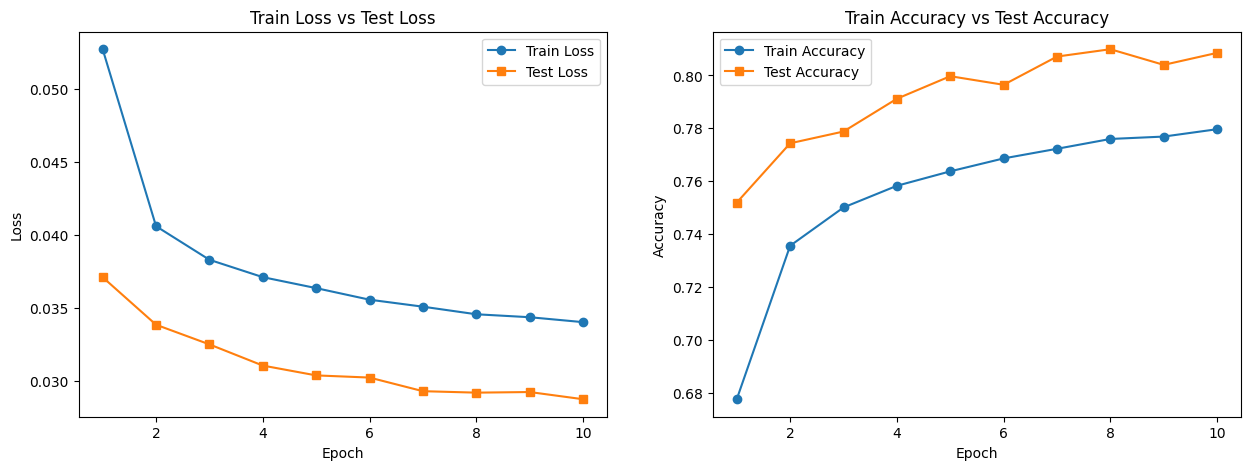

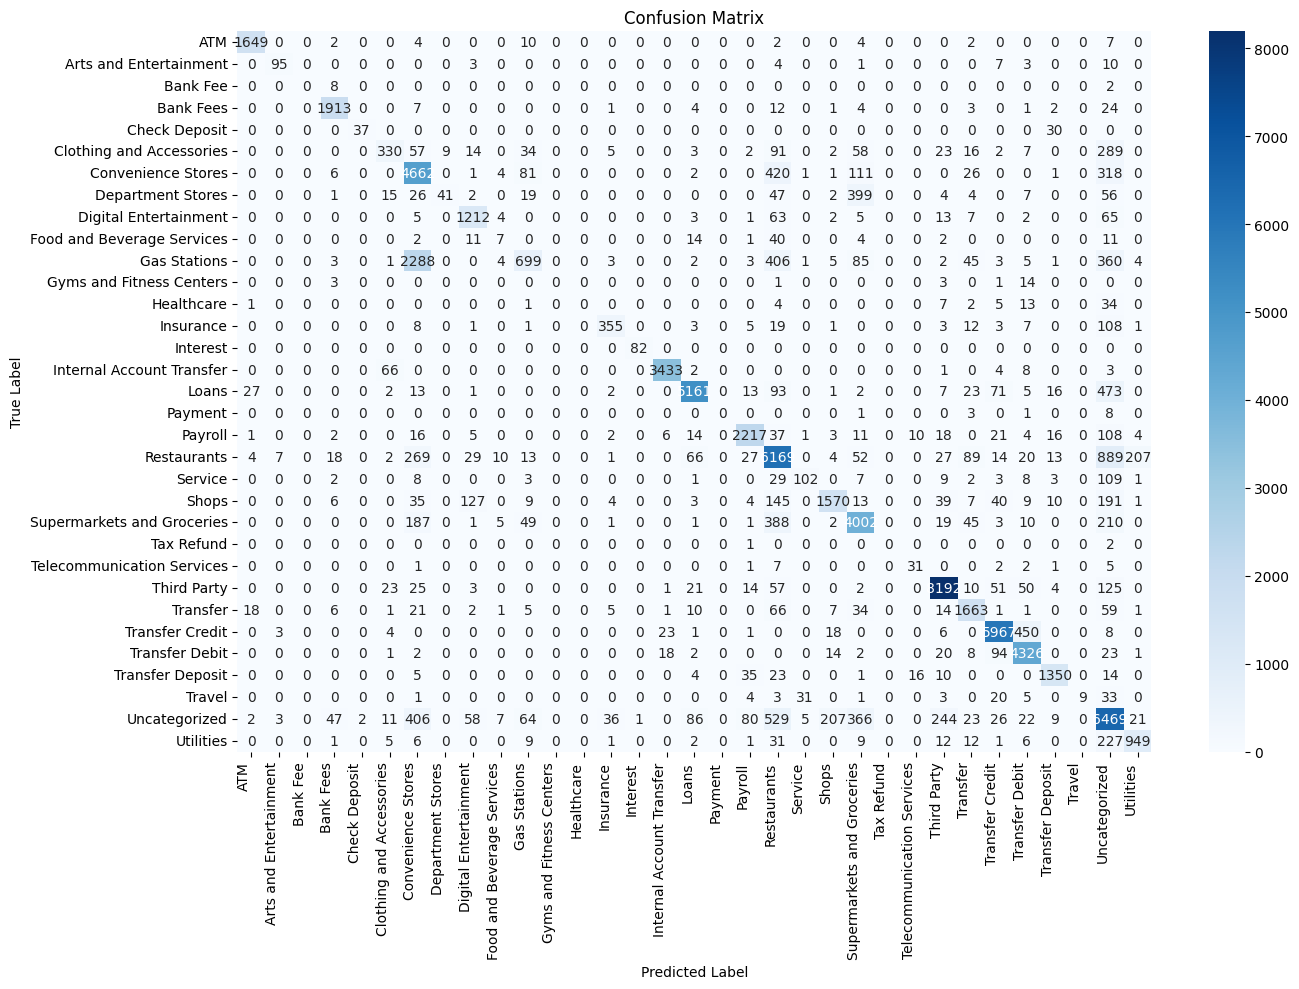

                            precision    recall  f1-score   support

                       ATM       0.97      0.98      0.98      1680
    Arts and Entertainment       0.88      0.77      0.82       123
                  Bank Fee       0.00      0.00      0.00        10
                 Bank Fees       0.95      0.97      0.96      1972
             Check Deposit       0.95      0.55      0.70        67
  Clothing and Accessories       0.72      0.35      0.47       942
        Convenience Stores       0.58      0.83      0.68      5634
         Department Stores       0.82      0.07      0.12       623
     Digital Entertainment       0.82      0.88      0.85      1382
Food and Beverage Services       0.17      0.08      0.10        92
              Gas Stations       0.70      0.18      0.28      3920
  Gyms and Fitness Centers       0.00      0.00      0.00        22
                Healthcare       0.00      0.00      0.00        67
                 Insurance       0.85      0.67

In [29]:
category_columns = [col for col in df.columns if col.startswith("category_")]
category_names = [col.replace("category_", "").replace("_", " ") for col in category_columns]  # Remove 'category_' prefix

model_name = "ANN_10e_1e-3lr_bce_classifier"

# Train and evaluate the model
train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, category_names, model_name, save_results=False, num_epochs=10, device=device)

## Model Inference

This section serves as an example of the pipeline predicting the category of *new unseen* transaction (`inference.csv`). This dataset is sourced from the original `bank_transaction.csv` dataset, i.e. 257 instances with missing class labels. These instances were dropped during preprocessing hence **not seen** during training.

These instances have no ground truth, let's see how the trained model is going to predict their categories :) 

Pipeline includes:
1. Data preprocessing (numerical + text)
2. Loading trained model weights
3. Model Inference

#### Load and Preprocess the New Inference Dataset

In [30]:

import pandas as pd
import numpy as np
import torch
import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the text cleaning function from the util folder
from util.text_cleaning import clean_normalize_text

# Load the raw training dataset
df = pd.read_csv("../dataset/preprocessed_bank_transaction.csv")

# Load the new dataset for inference
inference_df = pd.read_csv("../dataset/inference.csv")

# Load the FastText model
from gensim.models import FastText
fasttext_model = FastText.load("../models/fasttext/fasttext_model.bin")

# Load the trained scaler
SCALER_PATH = "../models/scaler/scaler.pkl"
with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)

#### Defining Data Preprocessing Function

In [31]:
def preprocess_new_data(df, fasttext_model, scaler, structured_features):
    """Preprocess the new dataset without requiring a category column."""

    # Drop unnecessary columns (if exist)
    df = df.drop(columns=['client_id', 'bank_id', 'account_id', 'txn_id'], errors='ignore')

    # Convert txn_date to datetime format (if applicable)
    if 'txn_date' in df.columns:
        df['txn_date'] = pd.to_datetime(df['txn_date'], errors='coerce')

        # Extract time-based features
        df['day_of_week'] = df['txn_date'].dt.dayofweek  # Monday=0, Sunday=6
        df['day_of_month'] = df['txn_date'].dt.day  # 1-31
        df['hour'] = df['txn_date'].dt.hour  # Extract hour from transaction time (0-23)
        df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 1=Weekend, 0=Weekday

        # Drop original txn_date column
        df = df.drop(columns=['txn_date'], errors='ignore')

    # Ensure transaction descriptions are cleaned first
    if 'description' in df.columns:
        df['processed_description'] = df['description'].fillna('').apply(clean_normalize_text)
    else:
        raise KeyError("Column 'description' is missing in the dataset!")

    # Generate FastText embeddings from cleaned transaction descriptions
    def get_embedding(text):
        words = str(text).split()  # Convert text to words
        word_vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
        if len(word_vectors) == 0:
            return np.zeros(100, dtype=np.float32)  # Ensure float32 dtype
        return np.mean(word_vectors, axis=0).astype(np.float32)  # Ensure float32 dtype

    df['fasttext_embedding'] = df['processed_description'].apply(get_embedding)
    fasttext_embeddings = np.vstack(df['fasttext_embedding'].values).astype(np.float32)  # Ensure float32

    # Drop raw text columns
    df = df.drop(columns=['description', 'processed_description', 'fasttext_embedding'], errors='ignore')

    # Apply the SAME scaler to inference data
    numerical_features = ['amount', 'day_of_week', 'day_of_month', 'hour']
    df[numerical_features] = scaler.transform(df[numerical_features])

    # Ensure correct data type
    df[structured_features] = df[structured_features].astype(np.float32)

    # Combine structured features and FastText embeddings into final feature matrix
    X_new = np.hstack((df[structured_features].values, fasttext_embeddings)).astype(np.float32)

    return X_new

In [32]:
# Extract structured numerical features (same as training)
structured_features = ['amount', 'is_interested_investment', 'is_interested_build_credit', 'is_interested_increase_income', 'is_interested_pay_off_debt', 'is_interested_manage_spending', 'is_interested_grow_savings', 'day_of_week', 'day_of_month', 'hour', 'is_weekend']

# Extract category column names from training dataset (ensuring consistent one-hot encoding)
category_columns = [col for col in df.columns if col.startswith("category_")]

# Preprocess new dataset
X_new = preprocess_new_data(inference_df, fasttext_model, scaler, structured_features)

# Convert to PyTorch tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

# Print shape
print("New dataset shape after preprocessing:", X_new_tensor.shape)

New dataset shape after preprocessing: torch.Size([257, 111])


#### Initialise and Load the Trained Model

For this inference, I'll be using the model trained with:

- 50 epochs
- 0.001 learning rate
- BCELoss() as loss function
- 82% average accuracy

In [33]:
import torch
import torch.nn as nn
from model import TransactionClassifier

# Load the trained model 
model_path = "../models/ann/ANN_50e_1e-3lr_bce_classifier.pth" 

# Initialize the model
model = TransactionClassifier(X_new_tensor.shape[1], len(category_columns))

model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()  # Set model to evaluation mode

TransactionClassifier(
  (fc1): Linear(in_features=111, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=33, bias=True)
  (sigmoid): Sigmoid()
)

#### Predicting Transaction Categories (Inference)

Since these instances have no ground truth, it's therefore not feasible to obtain its accuracy. I'll just print out the transaction description and the model prediction to roughly get an idea of how the model is performing!

In [34]:
# Perform inference
with torch.no_grad():
    outputs = model(X_new_tensor)  # Get model predictions
    predicted_categories = (outputs > 0.5).float()  # Convert logits to binary (threshold = 0.5)

# Convert one-hot predictions back to category labels
predicted_labels = []

for pred in predicted_categories.cpu().numpy():
    predicted_index = pred.argmax()  # Get index of the highest probability category
    predicted_labels.append(category_columns[predicted_index])  # Map index to category column

# Print the results
print("\n===== Model Predictions =====")

for i, (original, predicted) in enumerate(zip(inference_df['description'], predicted_labels)):
    print(f"Transaction {i+1}:")
    print(f"  Description: {original}")
    print(f"  Predicted Category: {predicted}")
    print("-" * 50)


===== Model Predictions =====
Transaction 1:
  Description: Transfer from Chime Savings Account
  Predicted Category: category_Transfer Credit
--------------------------------------------------
Transaction 2:
  Description: Transfer from Chime Savings Account
  Predicted Category: category_Transfer Credit
--------------------------------------------------
Transaction 3:
  Description: Transfer from Chime Savings Account
  Predicted Category: category_Transfer Credit
--------------------------------------------------
Transaction 4:
  Description: Cash app*cash out      visa direct  caus
  Predicted Category: category_Third Party
--------------------------------------------------
Transaction 5:
  Description: Transfer from Chime Savings Account
  Predicted Category: category_Transfer Credit
--------------------------------------------------
Transaction 6:
  Description: Transfer from CB
  Predicted Category: category_Transfer Credit
--------------------------------------------------
Tra